### IMPORTS

In [1]:
# Librerías para llamar a la API de Spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

# Librerías para la manipulación de datos
import pandas as pd
from collections import Counter
import pprint
from random import shuffle
from IPython.display import Image
import time
import json

pd.set_option("display.max_rows", 100)

### GLOBAL VARIABLES

In [2]:
# Importo las variables globales de otros archivos
import global_variables as gv
genres = gv.genres
client_ID = gv.client_ID
client_secret = gv.client_secret
sp = gv.sp
host = gv.host
find_URI = gv.find_URI

# La variable artists_genres se nutre cada vez que una canción nueva pasa por mi pipeline, 
with open('artists_genres.json') as json_file:  
    artists_genres = json.load(json_file)

### USERS IDENTIFICATION

In [3]:
# Recibo los Spotify URI's de los usuarios que van a linkear su música

def receive_users():
    
    print("Enter the Spotify URIs of the profiles you would like to link.\n")
    print("You can easily find your profile URI by following these 4 steps on the Spotify app:\n")
    display(find_URI)
    users_input = input("\n Paste your Spotify URIs ('spotify:user:username') here, separating them by '//':"
                        ).split("//")

# Creo un diccionario donde guardo los URI con sus display names correspondientes, para llamar 
# a cada usuario por su nombre cuando le pida que seleccione playlists.
    users = {}
    for user in users_input:
        display_name = sp.user(user[13:])["display_name"]
        if display_name != None:
            users[user[13:]] = display_name
        else:
            users[user[13:]] = user[13:]
        
# Devuelvo ese diccionario
    return users

### OBTAIN USERS' PLAYLISTS

In [4]:
# Para que los usuarios puedan escoger de entre sus playlists, las obtengo a través de
# sp.user_playlists, y se las muestro para que puedan seleccionarlas sin volver a Spotify.

def get_user_playlists(users):
    
# Creo un diccionario donde voy a relacionar cada usuario con un listado de las URIs de 
# sus playlists.  
#                  {user1: [pl1_name, pl2_name,...], user2: [pl1_name, pl2_name,...],...}

    users_playlists_names = {}

# Creo otro donde también incluyo el URI de cada playlist, además del nombre

#                  {user1: {pl1_name: pl1_URI, pl2_name: pl2_URI}, ...}

    users_playlists_names_URIs = {}

# Para cada usuario, obtengo sus playlists, y guardo sus datos en ambos diccionarios.
    for user in users:
        playlists = sp.user_playlists(user)
        playlists_names = []
        users_playlists_names_URIs[user] = {}
        
        for i, playlist in enumerate(playlists["items"]):
            playlists_names.append(playlist["name"])
            users_playlists_names_URIs[user][playlist["name"]] = playlist['uri'][17:]
            
        users_playlists_names[user] = playlists_names
    
# Aquí podría cortar la función, llamando a lo de arriba “get_users_info" y guardándolo en 
# una variable global.


# Creo una variable que va a contener los datos de la petición (playlist por usuario, 
# género a filtrar, y nombre de la nueva lista).
  
#                mygroup = {"users": {user1: [playlists_to_select], 
#                                     user2: [playlists_to_select]},
#                           "genres": [genres_to_select],
#                           "new_playlist_name": name}

    mygroup = {"users": {}}
    for user in users:
        mygroup["users"][user] = {} 
        

# Doy la opción a los usuarios de escoger si quieren seleccionar todas sus playlists
# o no, para que, en caso de querer seleccionar todas, no tengan que ir uno a uno 
# escribiendo "all".

    select_playlists = input("""
     If you would like to select which playlists from your profiles to submit, write 'select'. 
                             
     If you rather want to submit them all, write 'all'
                             
     """)
    
# Si han escogido "all", entonces en mygroup se guarda ["all"] en playlists_to _select
# para todos los usuarios.
        
    if select_playlists == "all":
        for user in users:
            mygroup["users"][user]["playlists"] = ["all"]      
        
# Si han escogido "select", entonces en playlists_to_select se guarda la lista de 
# playlists que introduzcan en el siguiente input, donde muestro su display_name
# y el nombre de todas sus playlists.

    else:    
        for user in users:
            mygroup["users"][user]["playlists"] = input(
                """
                ·················································
                ·················································
                ·················································

                {} , enter the Spotify playlists you would like to submit, separated by '//'. 

                These are all your public playlists: 

                {} 
                
                If you want to submit all, just write "all"

                """
                .format(users.get(user), users_playlists_names[user])).split("//")

# Una vez han seleccionado las playlists que quieran subir, les ofrezco el filtro 
# por género. Recibo su respuesta a través de un input donde le muestro los géneros
# generales de entre los que pueden seleccionar, y la guardo en mygroup["genres"].

    mygroup["genres"] = input(
            """
            ·················································
            ·················································
            ·················································
            
            Now select the genres of the songs for your new playlist.
                        
            You can select out of the following:
    
            {} 
            
            
            If you don't want to filter by genre, just write "any"
            
            Again, separate by '//'
                        
            """
            .format(list(genres.keys()))).split("//")

# Finalmente, escriben el nombre de la nueva playlist, y lo guardo en 
# mygroup["new_playlist_name"]

    mygroup["new_playlist_name"] = input(
            """
            ·················································
            ·················································
            ·················································
            
            And finally, write the name for your new combined playlist :D            
            
            """
            )
    

# Devuelvo el diccionario donde relaciono los nombres de las playlists de un usuario con 
# sus URIs, mygroup, y el diccionario que relaciona URIs y nombres de usuarios.

    return users_playlists_names_URIs, mygroup, users

### OBTAIN TRACKS INFO

In [5]:
# Ahora que ya tengo las URIs de las listas a juntar, obtengo las canciones de esas listas,
# llamando a la API con la función sp.user_playlist_tracks.

def get_tracks_info(users_playlists_names_URIs, mygroup, users):
    
    print("""
    ·················································
    ·················································
    ·················································      
            
    """)
    

# Guardo la hora para calcular cuánto tarda desde aquí hasta el final.
    
    start_time = time.time()
    
# Creo una variable donde voy a relacionar a cada usuario con los listados de los temas 
# en sus playlists.        users_playlists_tracks = {user1_URI: [pl1_tracks, pl2_tracks, ...],
#                                                    user2_URI: [pl1_tracks, pl2_tracks, ...],...}

    users_playlists_tracks = {}

# Itero sobre cada usuario de la petición:

    for user in mygroup["users"].keys():
        
        print("Obtaining tracks info from {}".format(users.get(user)))

# Creo una variable para alistar los temas de cada playlist suya

        tracks_info = []

# Si el usuario ha escogido todas sus playlists, entonces obtengo todos los temas
# de todos los URIs de sus playlists en el diccionario users_playlists_names_IDs

        if mygroup["users"][user]["playlists"] == ["all"]:
            for playlist_URI in users_playlists_names_URIs[user].values():
                tracks_info.append(sp.user_playlist_tracks(user, playlist_id = playlist_URI))


# Si el usuario ha seleccionado de entre sus playlists, entonces obtengo todos los
# temas de solo las playlists que he guardado en su apartado de mygroup, encontrando
# sus respectivos URIs en el diccionario que relaciona nombres y URIs de playlists.

        else:
            for playlist in mygroup["users"][user]["playlists"]:
                tracks_info.append(sp.user_playlist_tracks(user, 
                                                           playlist_id = users_playlists_names_URIs[user][playlist]))
    
        users_playlists_tracks[user] = tracks_info


# Devuelvo el diccionario donde relaciono usuarios con los temas de sus playlists,
# mygroup, start_time, y users

    return users_playlists_tracks, mygroup, start_time, users

### OBTAIN FINAL TRACKS

In [6]:
# Ya tengo todos los temas de las playlists a combinar. Ahora tengo que obtener sus 
# URIs, nombres y artistas, y filtrarlos por género.

def get_final_tracks(users_playlists_tracks, mygroup, start_time, users):
    
# Creo un diccionario donde voy a guardar la información de los temas con los que me 
# voy a quedar.      final_tracks = {track_URI: {track_name: artist}}
    
    final_tracks = {}
    
# Creo listas vacías para introducir después sus valores en final_tracks.
# Si introdujese directamente los valores en final_tracks, al ser un diccionario,
# no guardaría repetidos, sino que reescribiría los valores de las key repetidas.

# Sin embargo, yo voy a necesitar la lista final_track_IDs con repetidos, para poder 
# así calcular más adelante la frecuencia de cada tema.
    
    final_track_URIs = []
    final_track_names = []
    final_track_artists = []
    
# Itero sobre cada usuario

    for user in users_playlists_tracks:
        
        print("Obtaining final tracks from {}".format(users.get(user)))
        
        # Para cada usuario creo una lista de sus canciones con valores únicos. 
        # Esto lo hago para evitar que un usuario con la misma canción en distintas
        # playlists incluya varias veces la canción en la lista final, dándole mayor 
        # popularidad porque se repite entre sus listas, pero sin que realmente sea 
        # popular entre los distintos perfiles.
        
        user_track_names = []
        user_track_URIs = []
        user_track_artists = []
        
# Itero sobre cada playlist de cada usuario

        for playlist in users_playlists_tracks[user]:
            #print(playlist)
        
        # Itero sobre cada tema de cada playlist
        
            for track in playlist["items"]:
                
                # Si no hay información sobre un tema en la información de la playlist,
                # no voy a poder utilizarlo:
                
                if track["track"] != None:
                    if track["track"]["name"] not in user_track_names:  # Aquí evito repetición.
                        
                        # Para poder filtrar el tema por género, necesito saber su artista:
                        
                        if track["track"]["album"]["artists"] != []:
                            
                            # Si los usuarios no han filtrado por género, cojo todos.
                            
                            if mygroup["genres"] == ["any"]:
                                user_track_names.append(track["track"]["name"])
                                user_track_URIs.append(track["track"]["id"])
                                user_track_artists.append(track["track"]["album"]["artists"][0]["name"])
                                
                            # Si los usuarios sí que han filtrado por género, cojo el
                            # URI del artista de la canción, y utilizo sp.artist para obtener
                            # el género del artista.

                            else:
                                artist_URI = track["track"]["album"]["artists"][0]["external_urls"]["spotify"][32:]
                                
                    # Tengo una variable global (artists_genres), donde voy guardando 
                    # artistas y sus géneros, para evitar llamadas a la API y reducir así
                    # el tiempo del proceso entero. 
                    # Si no tengo guardado a ese artista en la variable, entonces llamo a la
                    # API, y lo guardo en la variable con su género correspondiente.
                                
                                if artist_URI not in artists_genres:
                                    artist_info = sp.artist(artist_URI)
                                    artists_genres[artist_URI] = artist_info["genres"]
                                    
                    # Si alguno de los géneros incluidos en el general_genre que me han pasado 
                    # los usuarios aparece en el listado de géneros del artista (guardado ya en
                    # artists_genres), entonces meto la canción en la lista de canciones finales
                    # del usuario.

                                genre_in_artist = 0

                                for general_genre in mygroup["genres"]:
                                    for genre in genres[general_genre]:
                                        if genre in artists_genres[artist_URI]:
                                            genre_in_artist += 1
                                if genre_in_artist > 0:
                                    user_track_URIs.append(track["track"]["id"])
                                    user_track_names.append(track["track"]["name"]) 
                                    user_track_artists.append(track["track"]["album"]["artists"][0]["name"])
                                    
# Introduzco las listas de canciones finales del usuario en las listas globales de todos
# los usuarios. (Recuerda que lo he hecho para evitar repetición dentro de un mismo usuario).
                            
        for i in range(len(user_track_names)):
            final_track_URIs.append(user_track_URIs[i])
            final_track_names.append(user_track_names[i]) 
            final_track_artists.append(user_track_artists[i])    
            
# Y guardo las listas globales en el diccionario global (donde no se podrá medir la frecuencia).
    
    for i in range(len(final_track_URIs)):
        final_tracks[final_track_URIs[i]] = [final_track_names[i], final_track_artists[i]]
        
    
    # Hago este shuffle antes de ordenarlos por popularidad para evitar que las canciones con 
    # el mismo número de repeticiones se ordenen según el orden de introducción de los 
    # nombres de usuarios. Lo quiero aleatorio:
    
    shuffle(final_track_URIs)
    
    # Ordeno los temas por popularidad en una nueva variable
    
    final_track_URIs_pop = [item for items, c in Counter(final_track_URIs).most_common() for item in [items] * c]
    
    # Creo una lista para obtener valores únicos de los temas finales, ordenados por
    # popularidad
    
    final_track_URIs_unique_all = []
    
    for track_URI in final_track_URIs_pop:
        if track_URI not in final_track_URIs_unique_all:
            final_track_URIs_unique_all.append(track_URI)
            
    # La lista final va a tener como máximo 50 canciones:
            
    if len(final_track_URIs_unique_all) > 50: 
        final_track_URIs_unique = final_track_URIs_unique_all[:50]
    else:
        final_track_URIs_unique = final_track_URIs_unique_all
            
    print("READY!")
    
# Devuelvo el diccionario que relaciona URIs con nombres de temas y artistas, la lista de temas
# finales con valores únicos, la lista de temas finales con repetidos, mygroup y start_time

    return final_tracks, final_track_URIs_unique, final_track_URIs_pop, mygroup, start_time

### CREATE DATAFRAME FOR DJ

In [7]:
# Creo un dataframe que me muestre las canciones finales ordenadas por popularidad:
# su URI, nombre, artista y frecuencia.

def create_dataframe(final_tracks, final_track_URIs_unique, final_track_URIs_pop, mygroup, start_time):
    
# Creo listas que voy a utilizar como columnas en el dataframe

    tracks = []
    artists = []
    frequency = []

# Obtengo los datos de la lista ordenada de URIs finales, buscando sus datos correspondientes
# en el diccionario final_tracks, y contando la frecuencia de los temas en final_track_URIs_pop.

    for URI in final_track_URIs_unique:
            tracks.append(final_tracks.get(URI)[0])
            artists.append(final_tracks.get(URI)[1])
            frequency.append(final_track_URIs_pop.count(URI))
            
# Creo el dataframe

    final_tracks_df = pd.DataFrame(data = [final_track_URIs_unique, tracks, artists, frequency],
                                   columns = range(len(final_track_URIs_unique)), 
                                   index = ["ID", "Track", "Artist", "Frequency"]).T
    
    display(final_tracks_df)
    
# Devuelvo la lista de URIs de temas finales únicos, mygroup y start_time

    return final_track_URIs_unique, mygroup, start_time

### CREATE PLAYLIST ON SPOTIFY

In [8]:
# Teniendo ya el listado ordenado de URIs de los temas finales, creo la playlist en Spotify

def create_playlist(final_track_URIs_unique, mygroup, start_time):
    
# Para crear una playlist necesito un token especial.

    token = util.prompt_for_user_token(host,
                               "playlist-modify-public",
                               client_id = "{}".format(client_ID),
                               client_secret = "{}".format(client_secret),
                               redirect_uri = "https://example.com/callback/")
    

# Con la autorización del nuevo token, creo la nueva playlist en el perfil del perfil de 
# la aplicación.

    sp = spotipy.Spotify(auth = token)
    final_playlist = sp.user_playlist_create(host, mygroup["new_playlist_name"])
    
# Añado los temas a la nueva playlist:

    sp.user_playlist_add_tracks(host, final_playlist["uri"][17:], final_track_URIs_unique)
    
# Obtengo su URL, y la comparto con los usuarios:

    final_playlist_url = final_playlist["external_urls"]["spotify"]
    
    print("""
          ·················································
          ·················································
          ·················································
          
          Here's your new combined playlist: 
          
          {}
          
          ENJOY!
          """.format(final_playlist["external_urls"]["spotify"])
          )
    
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)
    

### PIPELINE

Enter the Spotify URIs of the profiles you would like to link.

You can easily find your profile URI by following these 4 steps on the Spotify app:



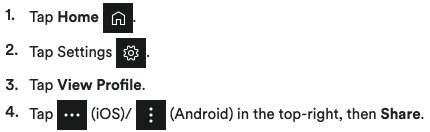


 Paste your Spotify URIs ('spotify:user:username') here, separating them by '//':spotify:user:sedepa//spotify:user:1163173670//spotify:user:119404049//spotify:user:azaba//spotify:user:diegolriveiro//spotify:user:1225636143//spotify:user:1152012320//spotify:user:luisarguel//spotify:user:alvarodiaztort//spotify:user:ycz169eekj80gcmz8jrifxit1//spotify:user:1116864324

     If you would like to select which playlists from your profiles to submit, write 'select'. 
                             
     If you rather want to submit them all, write 'all'
                             
     all

            ·················································
            ·················································
            ·················································
            
            Now select the genres of the songs for your new playlist.
                        
            You can select out of the following:
    
            ['Chill House', 'Indie', 'Pop', 'Rock', 'Latin', 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




{'href': 'https://api.spotify.com/v1/playlists/5JroRx8zKFua4mSX0gEQc6/tracks?offset=0&limit=100', 'items': [{'added_at': '2012-03-21T21:05:17Z', 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'}, 'href': 'https://api.spotify.com/v1/users/', 'id': '', 'type': 'user', 'uri': 'spotify:user:'}, 'is_local': False, 'primary_color': None, 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3PhoLpVuITZKcymswpck5b'}, 'href': 'https://api.spotify.com/v1/artists/3PhoLpVuITZKcymswpck5b', 'id': '3PhoLpVuITZKcymswpck5b', 'name': 'Elton John', 'type': 'artist', 'uri': 'spotify:artist:3PhoLpVuITZKcymswpck5b'}], 'available_markets': [], 'external_urls': {'spotify': 'https://open.spotify.com/album/6tKgjhjWDMVlgb3a6KoI1x'}, 'href': 'https://api.spotify.com/v1/albums/6tKgjhjWDMVlgb3a6KoI1x', 'id': '6tKgjhjWDMVlgb3a6KoI1x', 'images': [{'height': 634, 'url': 'https://i.scdn.co/image/ba51252f7d3c629c619c98c3aaac04355

READY!


,ID,Track,Artist,Frequency
0,3ehrxAhYms24KLPG8FZe0W,We Are Young (feat. Janelle Monáe),fun.,5
1,1Dl44SWywsIDdz1GgIp9gG,Infinity,The xx,5
2,4FK3lt7PTLvNXt6KoVOP0H,Queen Bee,Devendra Banhart,5
3,5qv0ohJV2QNwga79jLNDYQ,Hallelujah,Jeff Buckley,5
4,75JFxkI2RXiU7L9VXzMkle,The Scientist,Coldplay,5
5,3oU0VH9kbBIYnMvYey1KtB,Demon Host,Timber Timbre,5
6,57FxIRPEuGN9ZQatyt17Ka,Losing Keys,Jack Johnson,5
7,0uoI6LzLNgljbXK10YvzdK,No Other Way,Jack Johnson,5
8,294vBlXfZYspeI29SXZaON,Wake Me Up,Avicii,5
9,22QijL5pQXHqU6UdDjuLEC,A Sleeping Scene,Charles Pasi,5



          ·················································
          ·················································
          ·················································
          
          Here's your new combined playlist: 
          
          https://open.spotify.com/playlist/1msRNfSgn1TYddFxSroS3n
          
          ENJOY!
          
Elapsed time: 44.51309299468994


In [9]:
if __name__ == '__main__':
    
    users = receive_users()
    
    users_playlists_names_URIs, mygroup, users = get_user_playlists(users)
    
    users_playlists_tracks, mygroup, start_time, users = get_tracks_info(users_playlists_names_URIs, mygroup, users)
    
    final_tracks, final_track_URIs_unique, final_track_URIs, mygroup, start_time = get_final_tracks(users_playlists_tracks, mygroup, start_time, users)
    
    final_track_URIs_unique, mygroup, start_time = create_dataframe(
        final_tracks, final_track_URIs_unique, final_track_URIs, mygroup, start_time)
    
    create_playlist(final_track_URIs_unique, mygroup, start_time)
    

In [10]:
with open('artists_genres.json', 'w') as outfile:
    json.dump(artists_genres, outfile)

In [11]:
len(artists_genres)

17529